In [113]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AR


# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [31]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


In [32]:
df.describe()


,open,high,low,close,adjclose,volume
count,13569.000000,13569.000000,13569.000000,13569.000000,13569.000000,1.356900e+04
mean,1033.781691,1062.938694,1049.903098,1056.843079,1056.843079,1.578065e+09
std,1132.438600,1118.390759,1105.708344,1112.445231,1112.445231,1.869552e+09
min,0.000000,63.230000,60.959999,62.279999,62.279999,6.650000e+06
25%,157.899994,158.490005,157.100006,157.979996,157.979996,8.100000e+07
50%,754.719971,758.289978,747.590027,754.719971,754.719971,4.715900e+08
75%,1396.670044,1404.140015,1386.390015,1397.109985,1397.109985,3.276030e+09
max,4804.509766,4818.620117,4780.979980,4796.560059,4796.560059,1.145623e+10


# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

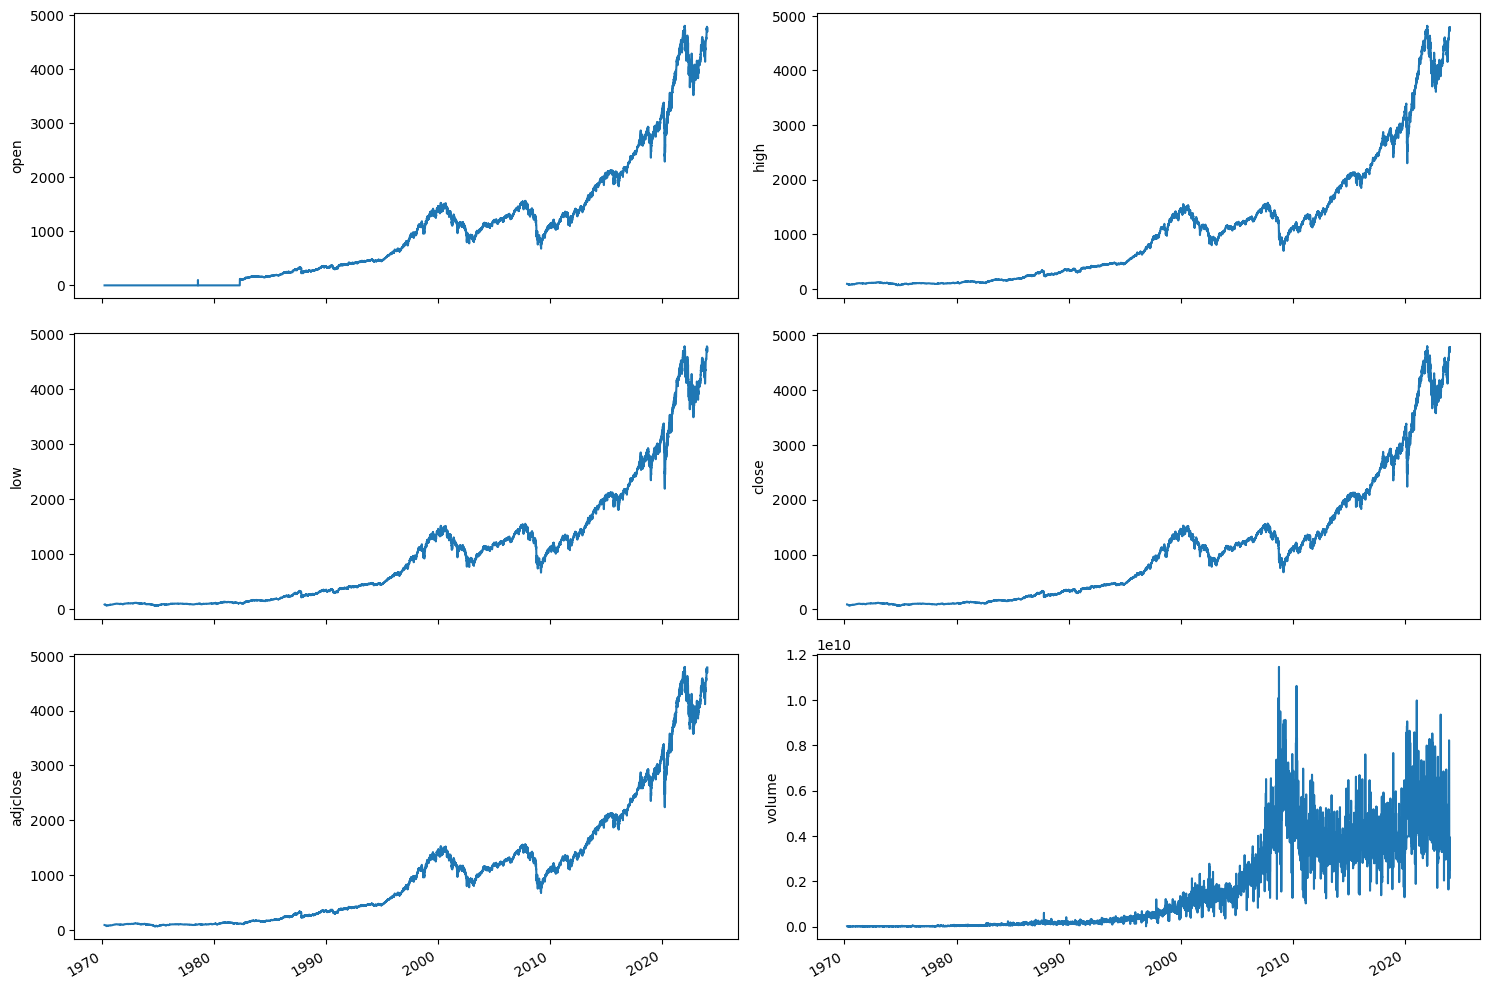

In [33]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

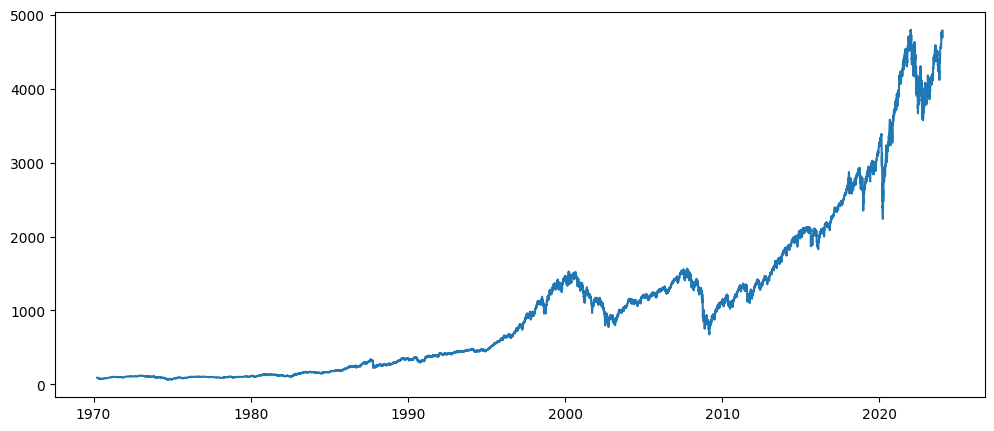

In [34]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [35]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

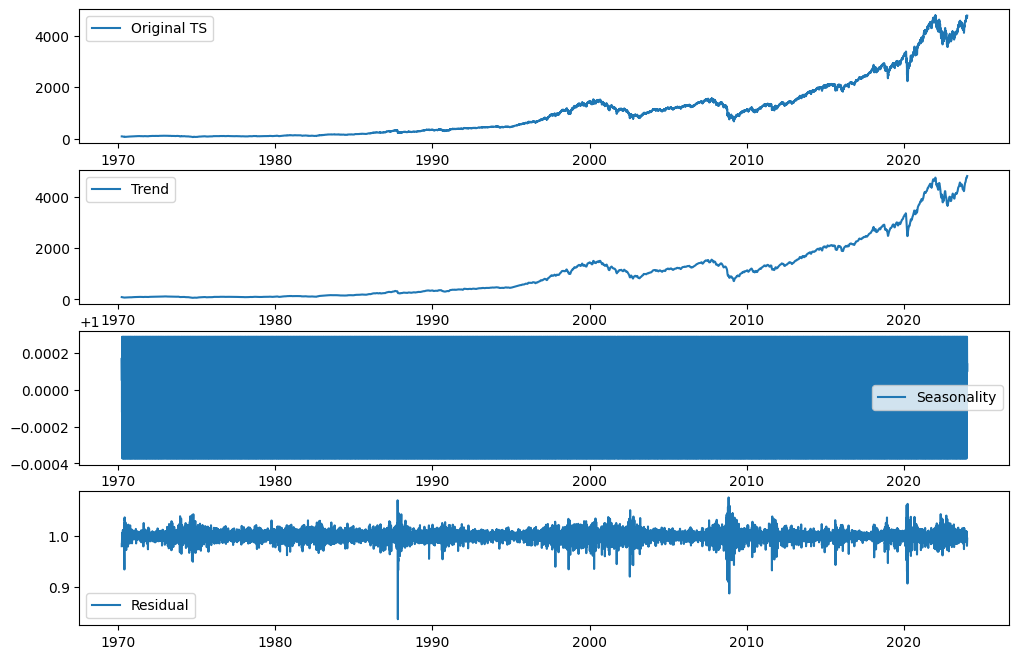

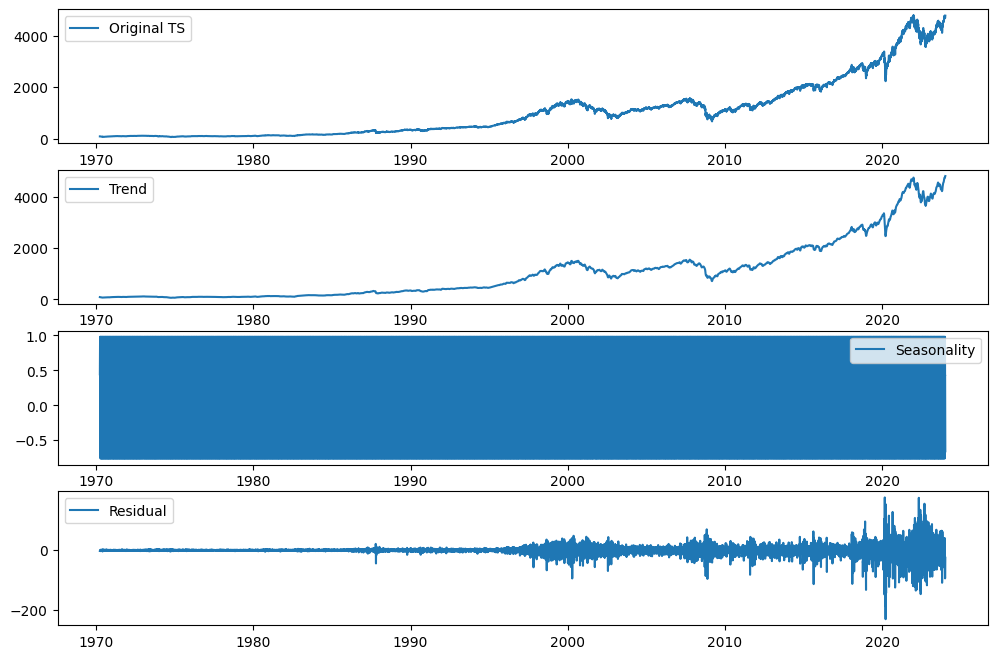

In [36]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

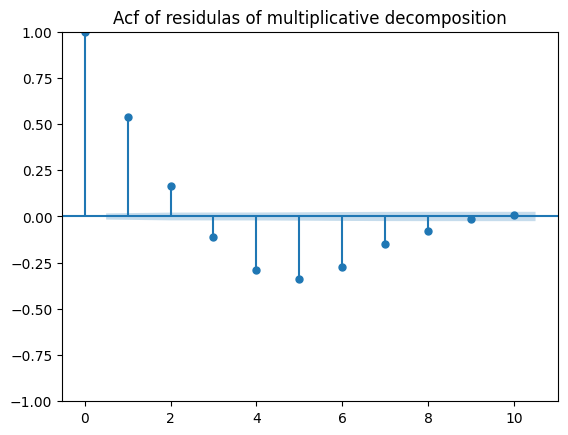

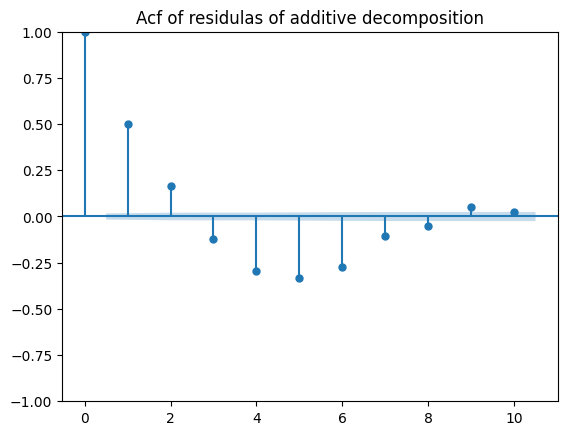

In [37]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

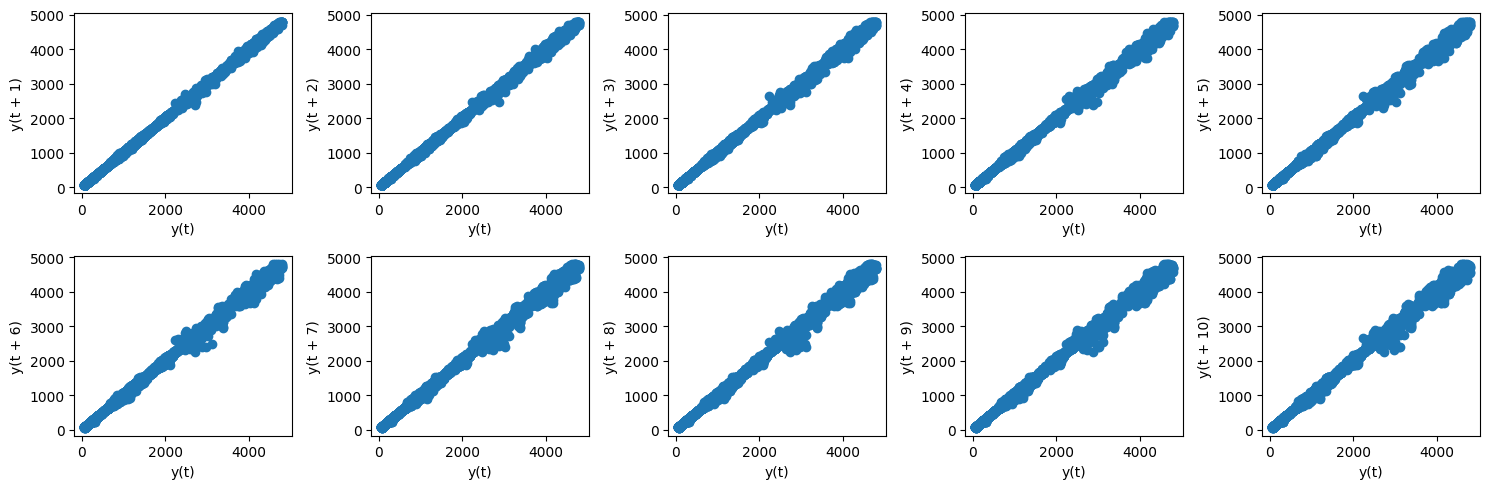

In [38]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

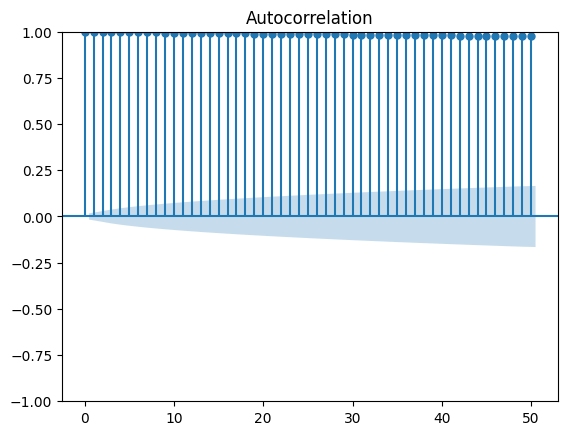

[1.         0.99943876 0.99890418 0.99835984 0.99783365 0.99731718
 0.99679317 0.99627671 0.99573488 0.99520821 0.99465882]


In [39]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [40]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


,open,high,low,close,adjclose,volume
count,13568.000000,13568.000000,13568.000000,13568.000000,13568.000000,1.356800e+04
mean,0.350821,0.346383,0.344051,0.345938,0.345938,1.579788e+05
std,15.678189,13.588251,15.348829,17.219983,17.219983,4.461424e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700005,-1.539978,-1.680002,-1.862579,-1.862579,-3.937750e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969978,2.500000,2.869995,2.932526,2.932526,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


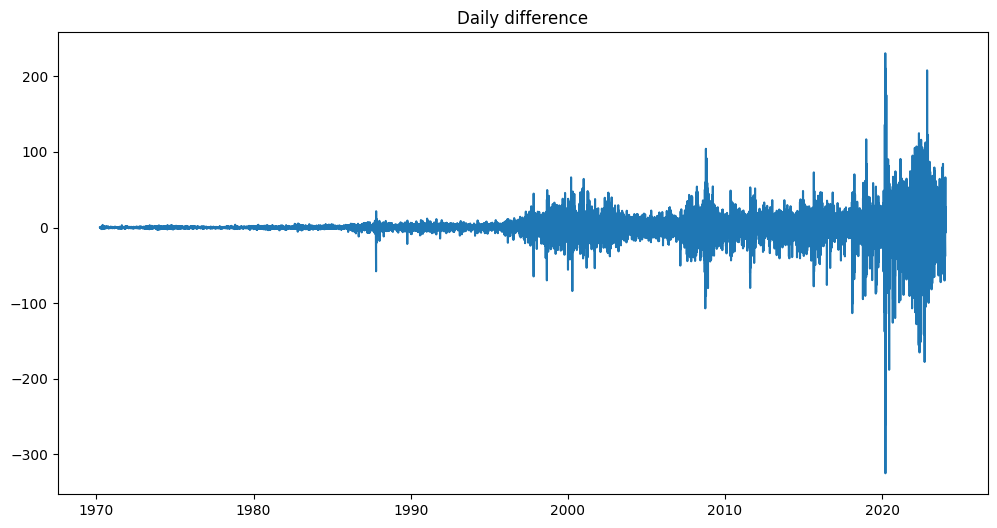

In [41]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [42]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.001388255174845
p-value: 0.0
Critical Values: {'1%': -3.4308335532641925, '5%': -2.861753707914063, '10%': -2.5668837518611642}
The time series is stationary.


KPSS Statistic: 0.7657239547510898
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_2240\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

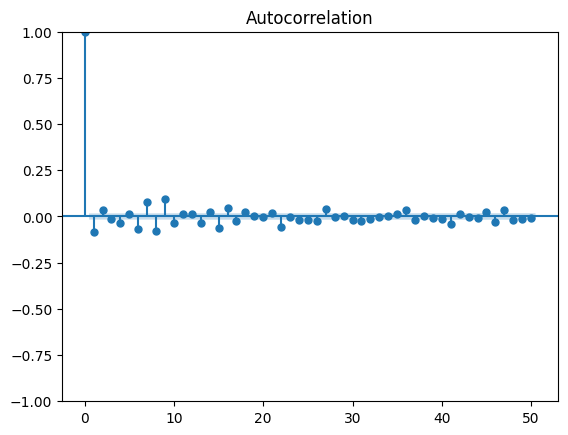

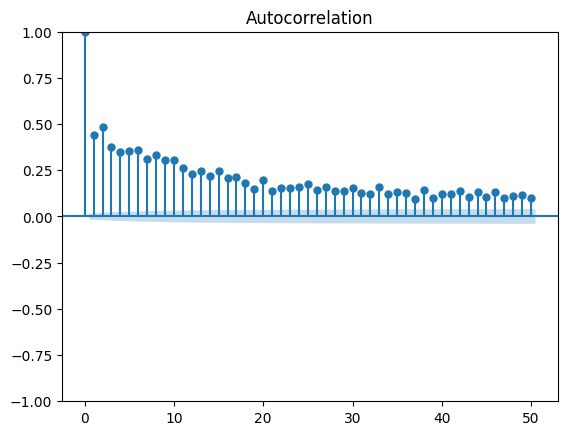

In [43]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

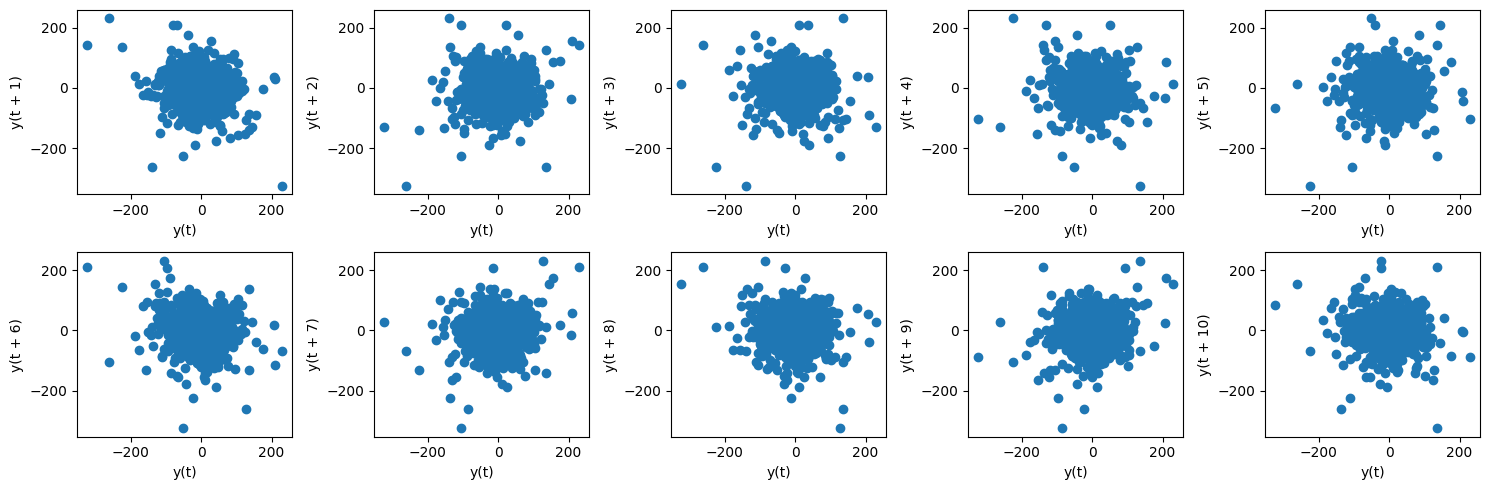

In [44]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

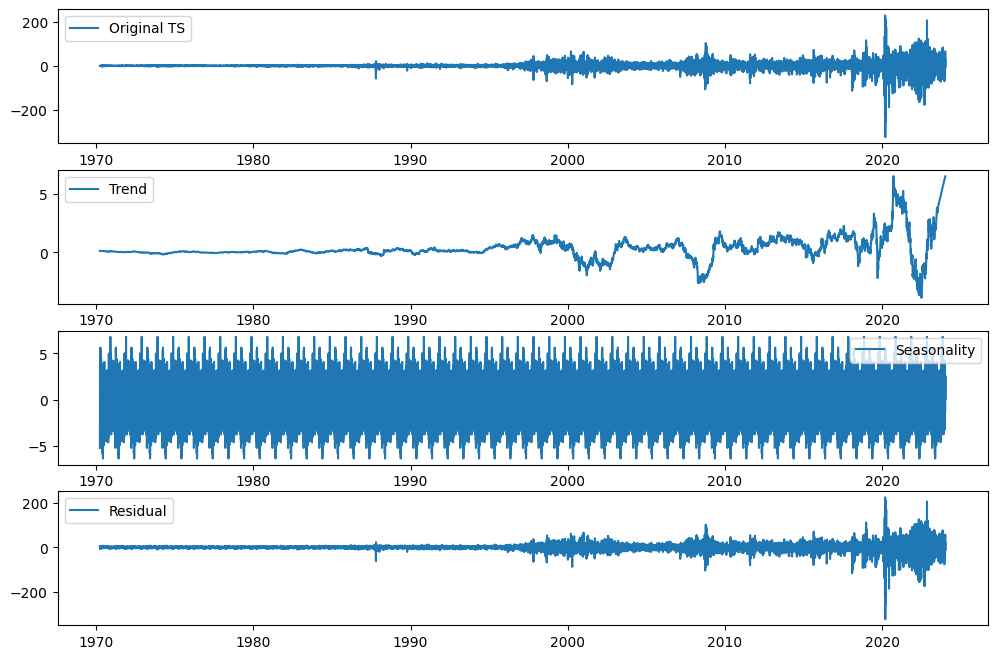

In [45]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

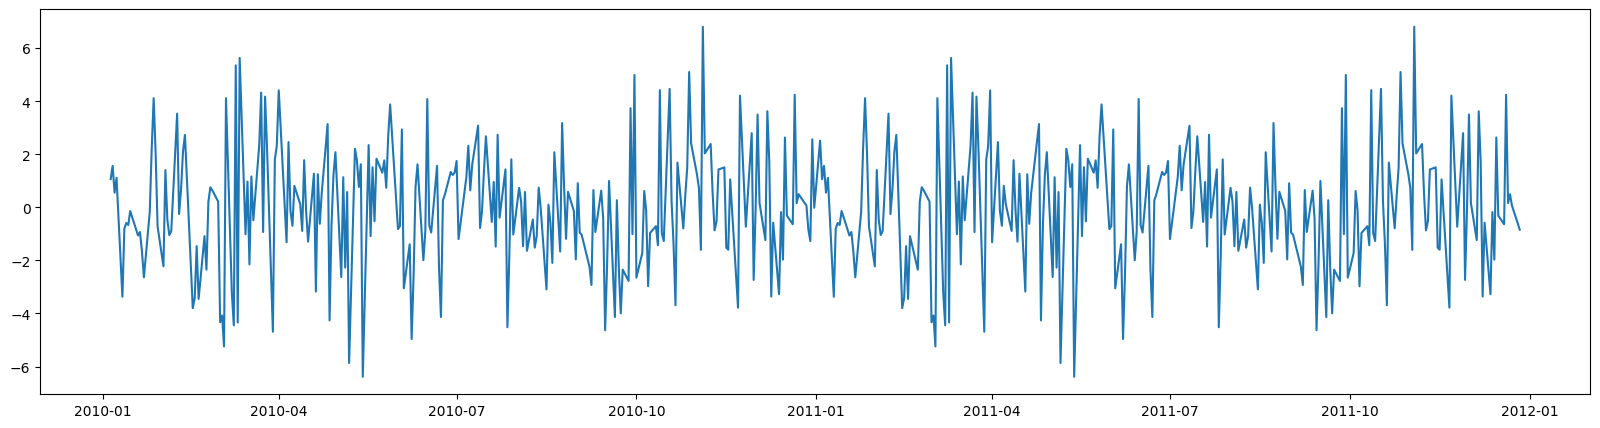

In [46]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

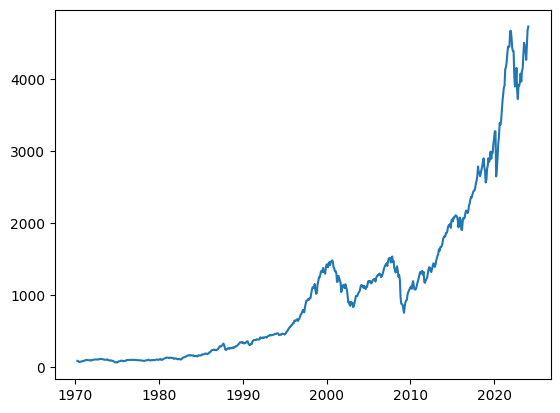

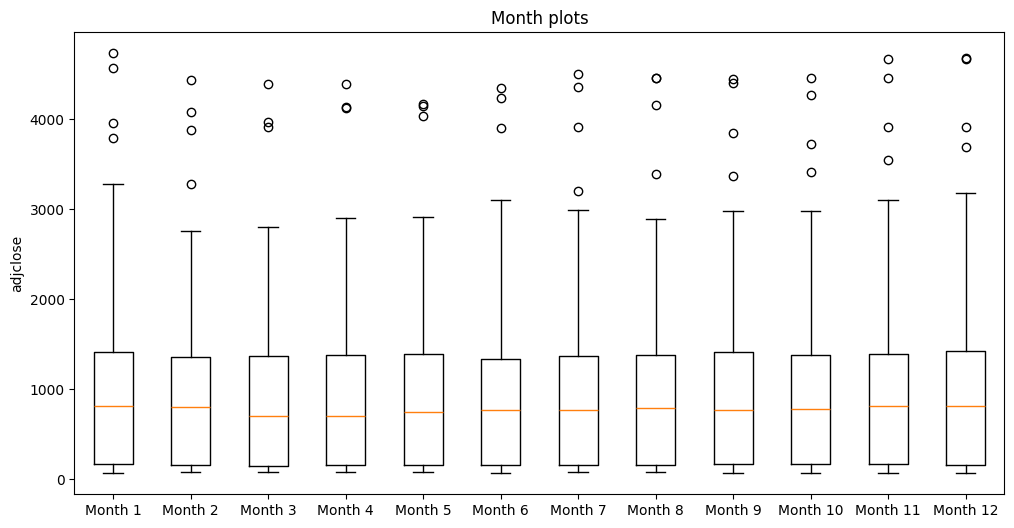

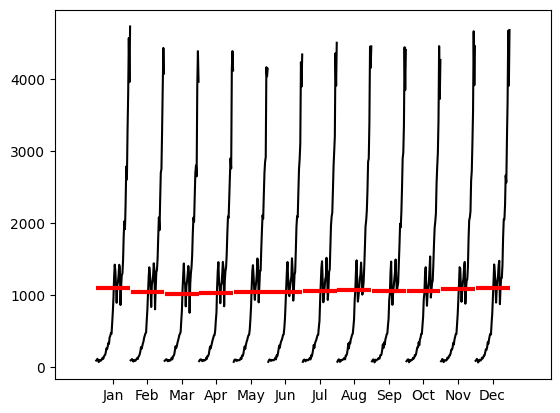

In [47]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

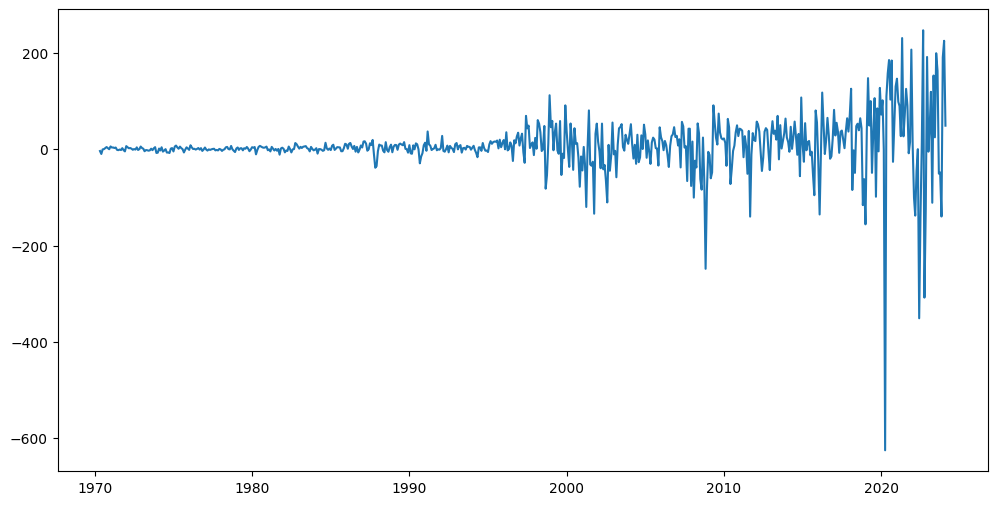

In [48]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

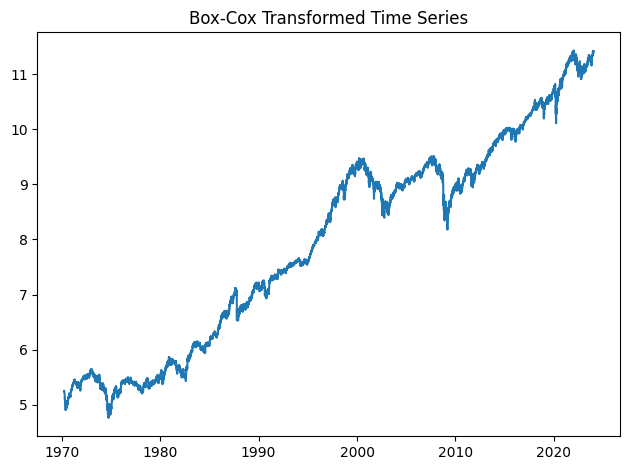

Optimal lambda value: 0.06724454461224579


In [49]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

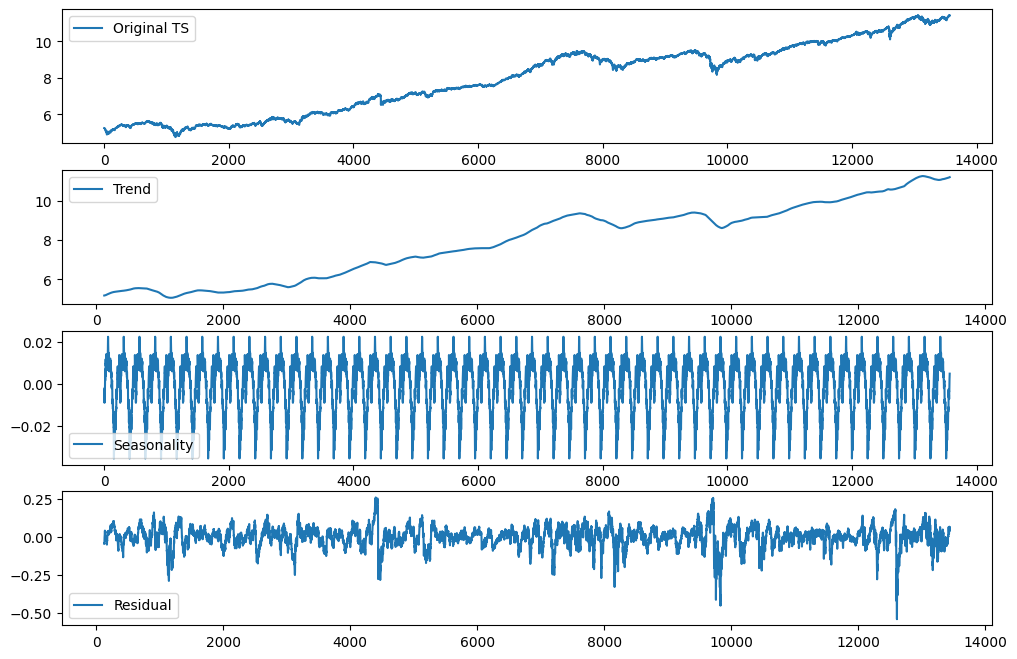

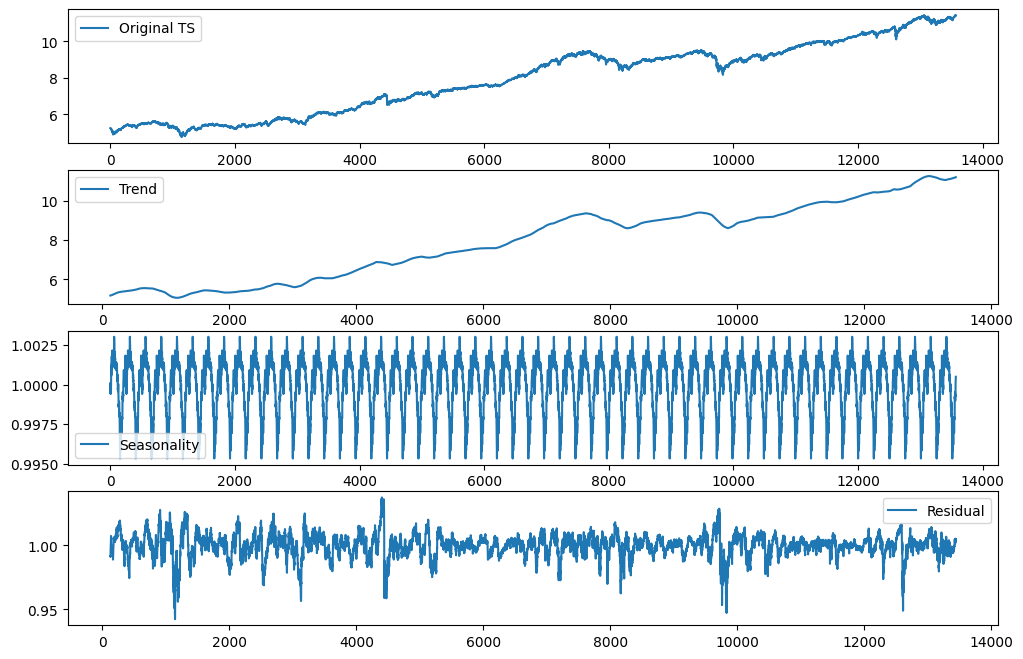

In [50]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

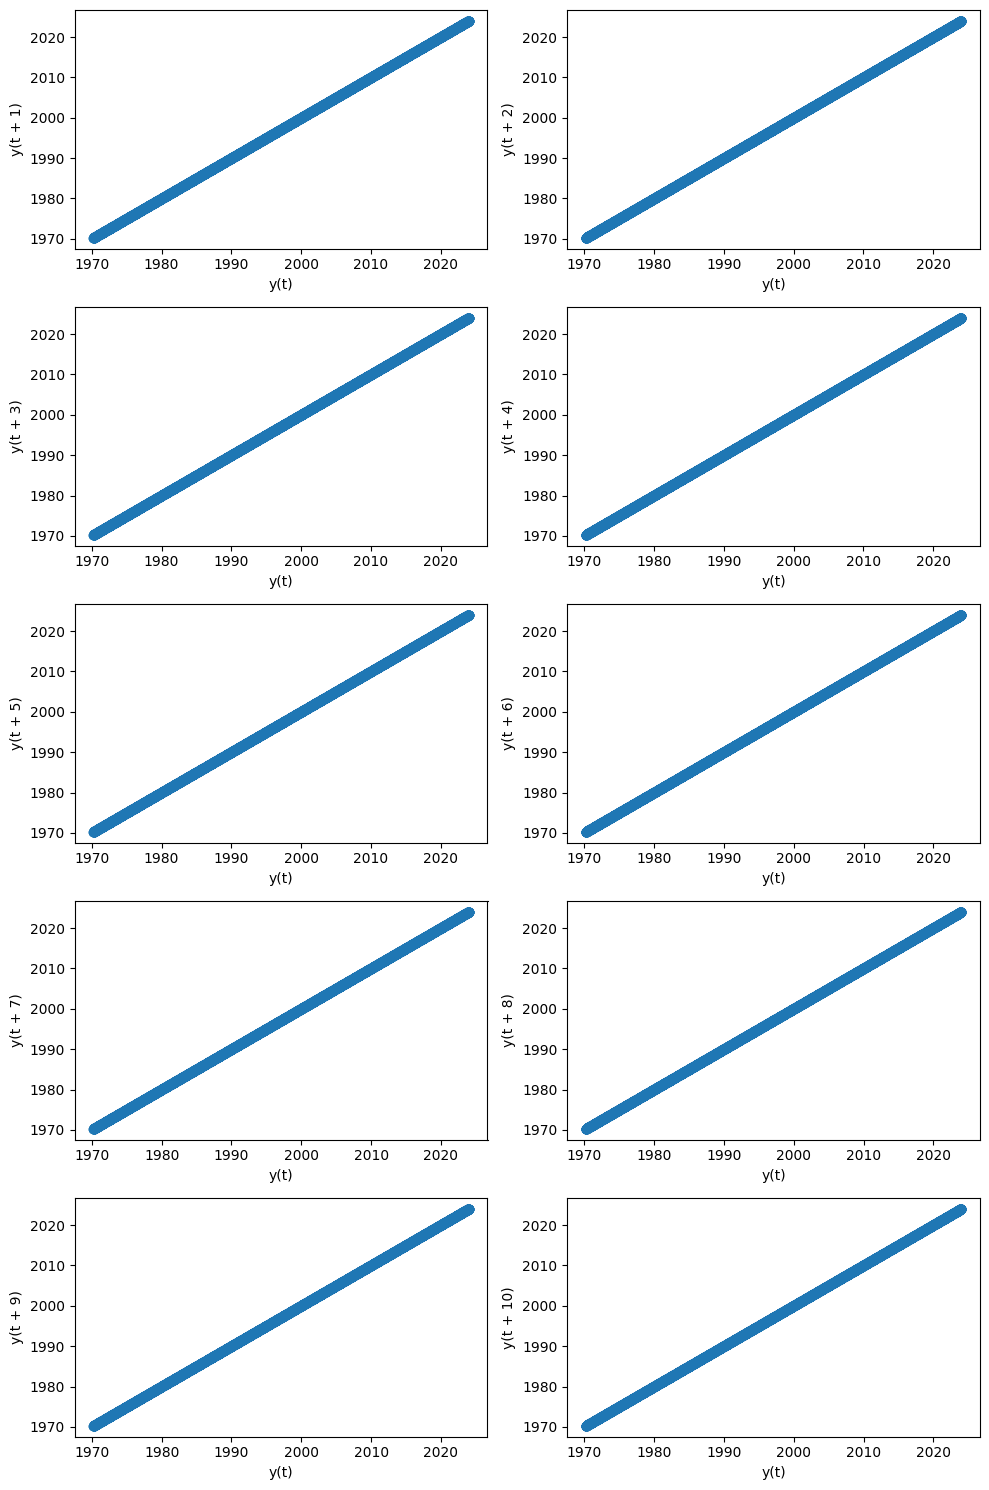

In [51]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

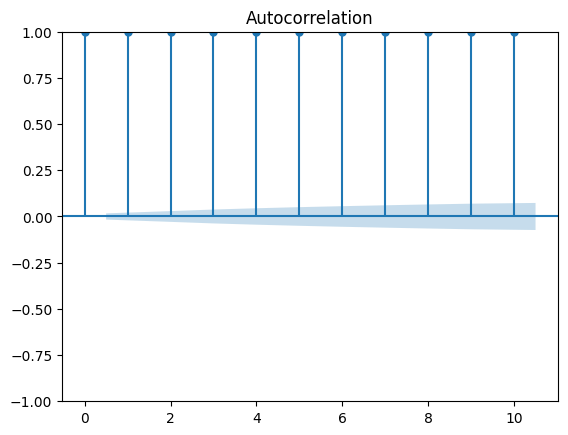

In [52]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [53]:
daily_diff.describe()

,open,high,low,close,adjclose,volume
count,13568.000000,13568.000000,13568.000000,13568.000000,13568.000000,1.356800e+04
mean,0.350821,0.346383,0.344051,0.345938,0.345938,1.579788e+05
std,15.678189,13.588251,15.348829,17.219983,17.219983,4.461424e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700005,-1.539978,-1.680002,-1.862579,-1.862579,-3.937750e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969978,2.500000,2.869995,2.932526,2.932526,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


# Model

In [114]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
returns_sqr = list(map(lambda x:x*x,returns))

Returns


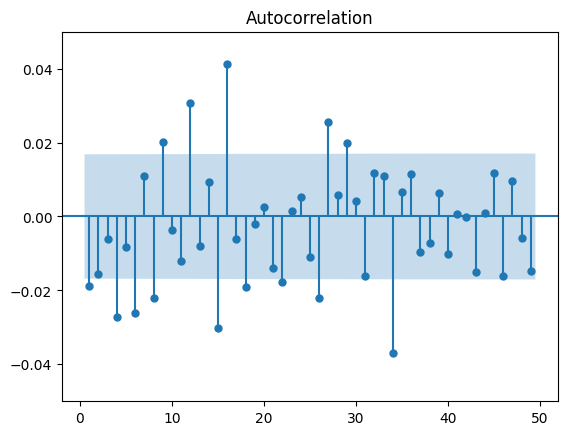

[ 1.         -0.01880949 -0.01568518 -0.00610211 -0.02707291 -0.00830519
 -0.02621948  0.01094766 -0.02209344  0.02015722 -0.00360942]

Returns squared


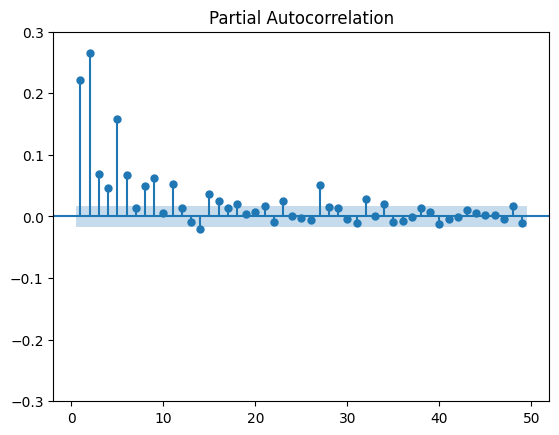

[1.         0.22140283 0.26581717 0.06895364 0.0463613  0.15817909
 0.06797477 0.01390179 0.05030352 0.06209247 0.00599041]


In [121]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

print("\nReturns squared")
pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.3,0.3)
plt.show()
print(pacf)

In [106]:
model = arch_model(returns,vol="ARCH",p=1)
result = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 906128981809007.4
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521753225.844452
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20432.600378314623
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19474.62394239555
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19435.58540456384
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19435.585380611577
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19435.585380611567
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19435.585380611577
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


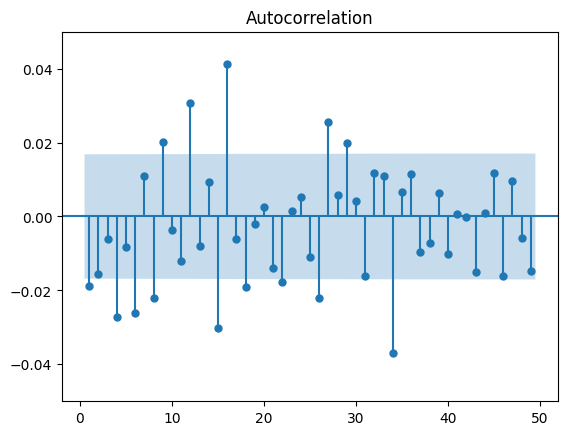

[ 1.         -0.01880949 -0.01568518 -0.00610211 -0.02707291 -0.00830519
 -0.02621948  0.01094766 -0.02209344  0.02015722 -0.00360942]


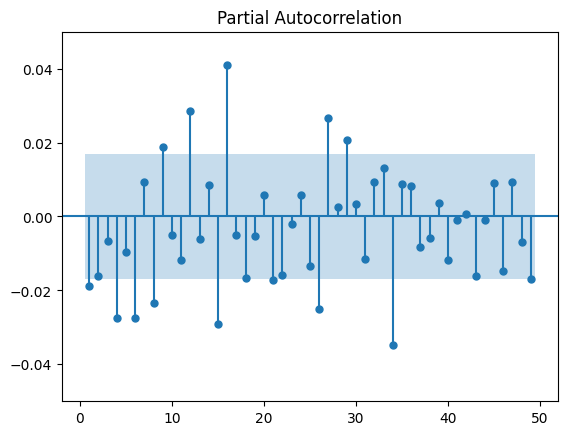

[ 1.         -0.01881088 -0.01604702 -0.00670925 -0.02759627 -0.00958149
 -0.02754931  0.00925106 -0.02354172  0.01880499 -0.00510303]


In [107]:
residuals =result.resid
acf= sm.tsa.acf(residuals,nlags=10)
tsaplots.plot_acf(residuals, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(residuals,nlags=10)
tsaplots.plot_pacf(residuals,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

In [111]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 906128981809007.4
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521753225.844452
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20432.600378314623
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19474.62394239555
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19435.58540456384
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19435.585380611577
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19435.585380611567
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19435.585380611577
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


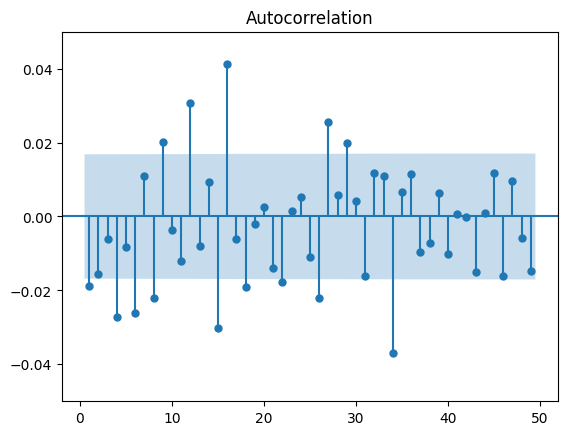

[ 1.         -0.01880949 -0.01568518 -0.00610211 -0.02707291 -0.00830519
 -0.02621948  0.01094766 -0.02209344  0.02015722 -0.00360942]


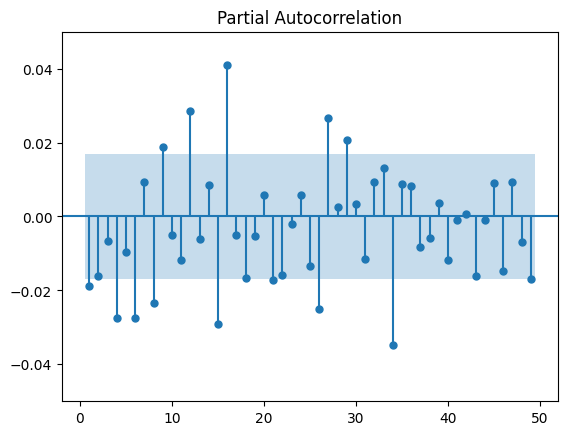

[ 1.         -0.01881088 -0.01604702 -0.00670925 -0.02759627 -0.00958149
 -0.02754931  0.00925106 -0.02354172  0.01880499 -0.00510303]


In [112]:
residuals =result.resid
acf= sm.tsa.acf(residuals,nlags=10)
tsaplots.plot_acf(residuals, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(residuals,nlags=10)
tsaplots.plot_pacf(residuals,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

# Final model

In [144]:
cutoff_test = int(len(returns) * 0.8)
data_train = returns.iloc[:cutoff_test]
data_test = returns.iloc[cutoff_test:]


In [145]:
model_garch = arch_model(data_train,vol="GARCH",p=1,q=1)
result = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 906128981809007.4
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521753225.844452
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20432.600378314623
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19474.62394239555
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19435.58540456384
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19435.585380611577
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19435.585380611567
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19435.585380611577
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


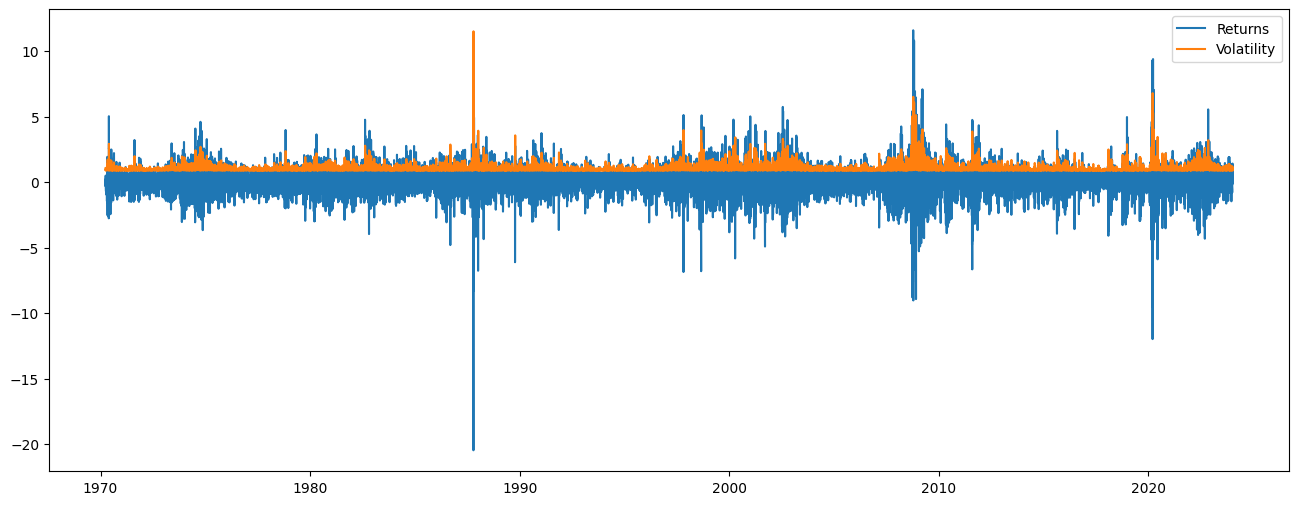

In [138]:
plt.figure(figsize=(16, 6))
plt.plot(returns, label='Returns')
plt.plot(result.conditional_volatility, label='Volatility')
plt.legend()
plt.show()

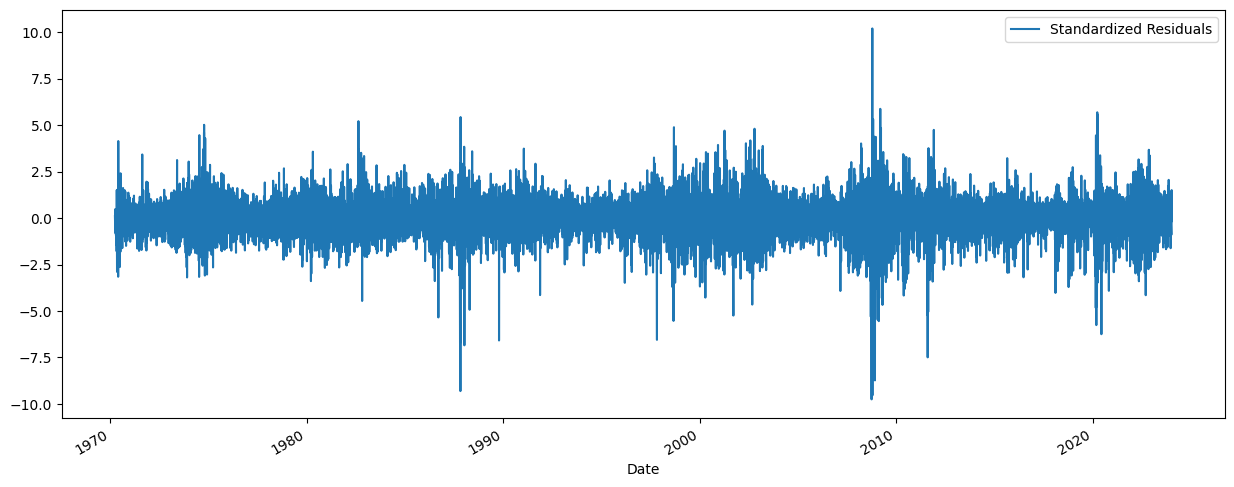

In [142]:
fig, ax = plt.subplots(figsize=(15, 6))

result.std_resid.plot(ax=ax, label='Standardized Residuals')

plt.xlabel('Date')

plt.legend()
plt.show()

In [151]:
predictions = result.forecast(horizon=100)


               h.001     h.002     h.003     h.004     h.005     h.006  \
2024-01-10  0.882016  1.075505  1.135917  1.154779  1.160668  1.162507   

               h.007    h.008     h.009     h.010  ...     h.091     h.092  \
2024-01-10  1.163081  1.16326  1.163316  1.163334  ...  1.163342  1.163342   

               h.093     h.094     h.095     h.096     h.097     h.098  \
2024-01-10  1.163342  1.163342  1.163342  1.163342  1.163342  1.163342   

               h.099     h.100  
2024-01-10  1.163342  1.163342  

[1 rows x 100 columns]


KeyError: 1

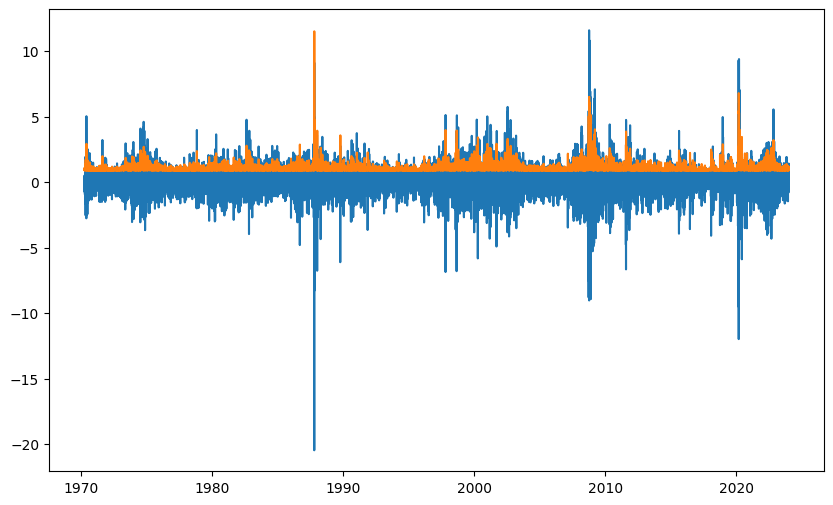

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Original Time Series')
plt.plot(result.conditional_volatility, label='Fitted Volatility')
plt.plot(np.arange(len(returns), len(returns) + 100), predictions.variance[1], 'ro', label='Forecasted Volatility')
plt.legend()
plt.show()